# Model Optimization
___

In [1]:
# MUST be the first cell in the notebook
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import random
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
import sys
from utils import load_it_data, visualize_img, compute_ev_and_corr
import matplotlib.pyplot as plt

import numpy as np
import gdown

In [2]:
def set_seed(seed=0):
    print('Deterministic code, set seed to', seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed = 6
set_seed(seed=seed)

Deterministic code, set seed to 6


In [3]:
import sys
!{sys.executable} -m pip install gdown h5py

In [4]:
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS
From (redirected): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS&confirm=t&uuid=31be07e1-395f-4ded-9de4-9becb1218b1e
To: /content/IT_data.h5
100%|██████████| 384M/384M [00:02<00:00, 133MB/s]


'IT_data.h5'

## Load the data

In [5]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [6]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


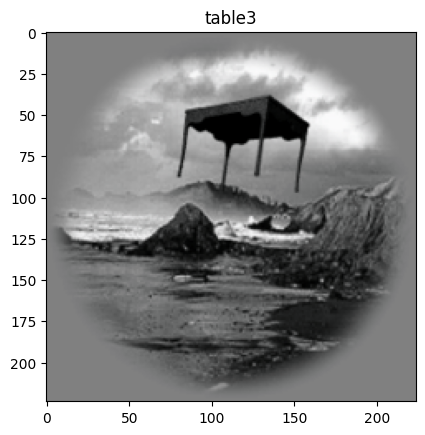

In [7]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

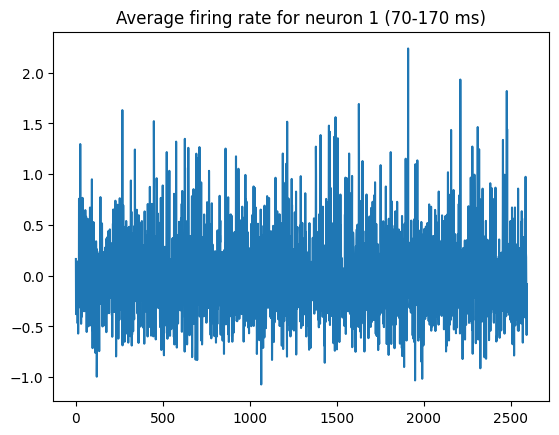

In [8]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

___

# In search for the best model:

### Funtions used in the rest of the notebook

In [9]:
class ITNeuralActivity(Dataset):
    def __init__(self, X, y=None, transform=None):
        """
        Custom Dataset for IT neural activity prediction.

        Args:
            X (numpy array): Input stimuli (e.g., images).
            y (numpy array, optional): Neural activity (e.g., spikes). Default is None for test data.
            transform (callable, optional): Optional transform to be applied on the input stimuli.
        """
        self.X = X
        self.y = torch.from_numpy(y).float() if y is not None else None
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]
        neural_activity = self.y[idx] if self.y is not None else None

        if self.transform:
            img = self.transform(torch.from_numpy(img).float())

        return (img, neural_activity) if neural_activity is not None else img


# Define the transform
transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets with the transform
train_dataset = ITNeuralActivity(stimulus_train, spikes_train, transform=transform)
val_dataset = ITNeuralActivity(stimulus_val, spikes_val, transform=transform)
test_dataset = ITNeuralActivity(stimulus_test, transform=transform)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
def train_model(model, train_dataloader, val_dataloader, loss_function, optimizer, epochs=10, device='cpu', scheduler=None):
    """
    Train the model and validate it after each epoch.

    Args:
        model (nn.Module): The neural network model.
        train_dataloader (DataLoader): DataLoader for training data.
        val_dataloader (DataLoader): DataLoader for validation data.
        loss_function (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        epochs (int): Number of training epochs.

    Returns:
        None
    """
    model.to(device)

    from torch.optim.swa_utils import AveragedModel, SWALR, update_bn
    swa_model     = AveragedModel(model)
    swa_start_ep  = 5                      # start averaging once val loss flattens
    swa_scheduler = SWALR(optimizer, swa_lr=1e-4)

    # Learning rate scheduler
    if scheduler is None:
        # Use StepLR scheduler with step size of 5 and gamma of 0.1
        scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for images, spikes in train_dataloader:
            images, spikes = images.to(device), spikes.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_function(outputs, spikes)

            # Backward pass & optimization
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, spikes in val_dataloader:
                images, spikes = images.to(device), spikes.to(device)

                # Forward pass
                outputs = model(images)
                loss = loss_function(outputs, spikes)

                val_loss += loss.item()

        # Step the learning rate scheduler
        scheduler.step()

        if epoch >= swa_start_ep:
          swa_model.update_parameters(model)
          swa_scheduler.step()

        # Print epoch results
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_dataloader):.4f}, "
              f"Val Loss: {val_loss/len(val_dataloader):.4f}")

        # Stop training if loss becomes NaN or Inf
        if torch.isnan(torch.tensor(train_loss)) or torch.isinf(torch.tensor(train_loss)):
            print("Training stopped due to unstable loss (NaN or Inf).")
            break

    # --- SWA finalisation (after the epoch loop) ---
    update_bn(train_dataloader, swa_model, device=device)

    # If swa_model came from a DataParallel‑wrapped network,
    # keep the inner module; otherwise keep swa_model itself.
    model = swa_model.module if hasattr(swa_model, "module") else swa_model


In [11]:
def evaluate_model(model, dataloader, spikes_val, device='cpu'):
    """
    Evaluate the model using explained variance and correlation.

    Args:
        model (nn.Module): The trained model.
        dataloader (DataLoader): DataLoader for the dataset to evaluate.
        spikes_val (numpy array): Ground truth neural activity for validation.
        loss_function (nn.Module, optional): Loss function (if needed for logging).
        device (str): Device to evaluate on ('cpu' or 'cuda').

    Returns:
        None
    """
    model.to(device)
    model.eval()

    # Compute explained variance & correlation
    overall_ev, overall_corr, ev_per_neuron, corr_per_neuron = compute_ev_and_corr(model, dataloader, spikes_val)

    print(f'Overall explained variance: {overall_ev:.4f}')
    print(f'Overall correlation: {overall_corr:.4f}')

    # Plot histograms for explained variance & correlation
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].hist(ev_per_neuron, bins=20, color='blue', alpha=0.7, edgecolor='black')
    axs[0].set_title('Explained Variance per Neuron')
    axs[0].set_xlabel('Explained Variance')
    axs[0].set_ylabel('Frequency')

    axs[1].hist(corr_per_neuron, bins=20, color='green', alpha=0.7, edgecolor='black')
    axs[1].set_title('Correlation per Neuron')
    axs[1].set_xlabel('Correlation Coefficient')
    axs[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

___

### Define the model (DeepNet201)

In [12]:
from torchvision.models import densenet201, DenseNet201_Weights

# Load ImageNet‑pretrained backbone
backbone = densenet201(weights=DenseNet201_Weights.IMAGENET1K_V1)

# Replace classifier: DenseNet uses nn.Linear(in_features, 1000) by default
in_features = backbone.classifier.in_features
n_neurons = spikes_train.shape[1]

backbone.classifier = nn.Linear(in_features, n_neurons)

model = backbone.cuda()
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")


Model parameters: 18,415,656


### Define the loss function and the optimizer

In [13]:
import torch.optim as optim

# Define the loss function
loss_function = nn.MSELoss()

# Define the optimizer
learning_rate = 0.001

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  ### Define a Scheduler

In [14]:
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR

base_lr     = 1e-3        # same as now
num_epochs  = 15          # keep your 15‑epoch budget
warmup_ep   = 2

warmup = LinearLR(optimizer,
                  start_factor=0.1,      # 0.1 × base_lr
                  end_factor=1.0,
                  total_iters=warmup_ep)

cosine = CosineAnnealingLR(optimizer,
                           T_max=num_epochs - warmup_ep,
                           eta_min=base_lr * 1e-3)   # ends 1000× lower

scheduler = SequentialLR(optimizer,
                         schedulers=[warmup, cosine],
                         milestones=[warmup_ep])

### Train model

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_model(model, train_dataloader, val_dataloader, loss_function, optimizer, epochs=10, device=device, scheduler = scheduler)


Epoch 1/10, Train Loss: 0.1200, Val Loss: 0.0911


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2/10, Train Loss: 0.0865, Val Loss: 0.0803
Epoch 3/10, Train Loss: 0.0780, Val Loss: 0.0825
Epoch 4/10, Train Loss: 0.0664, Val Loss: 0.0778
Epoch 5/10, Train Loss: 0.0570, Val Loss: 0.0737
Epoch 6/10, Train Loss: 0.0500, Val Loss: 0.0934
Epoch 7/10, Train Loss: 0.0432, Val Loss: 0.0665
Epoch 8/10, Train Loss: 0.0354, Val Loss: 0.0648
Epoch 9/10, Train Loss: 0.0292, Val Loss: 0.0610
Epoch 10/10, Train Loss: 0.0227, Val Loss: 0.0609


### Evaluate model

Overall explained variance: 0.4930
Overall correlation: 0.6967


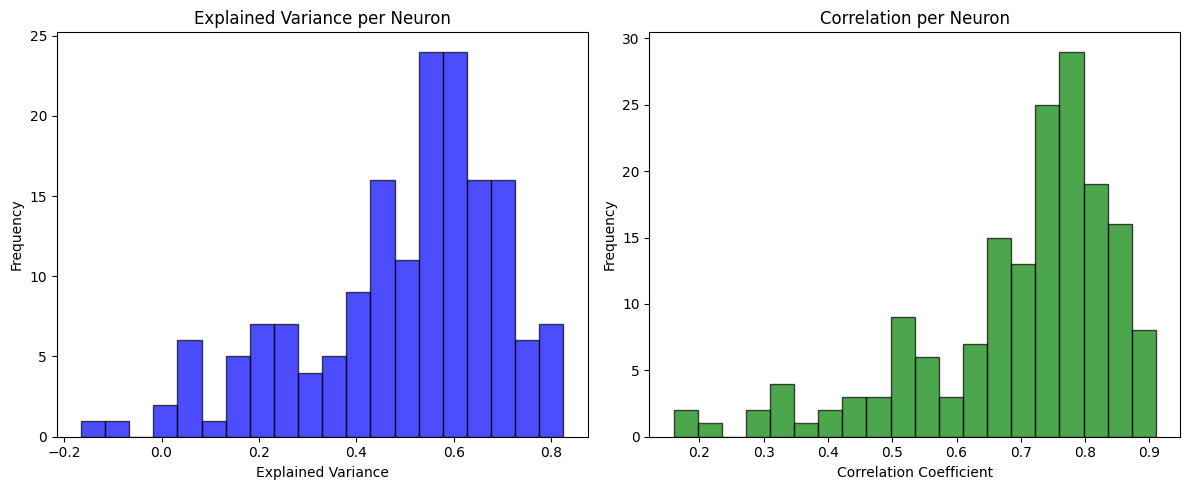

In [16]:
# Evaluate model on the validation set
evaluate_model(model, val_dataloader, spikes_val, device="cpu")

Reducing the epochs led to better performace, less overfitting....
Moreover, it seems like moving to a linear warm-up scheduler realy helps the mode, other optimizers were used but it seems that adam is the best option for our implemetantion.

___

# Trying other models adn optimizers, moderate amount of success...

### ResNet‑152

In [17]:
from torchvision.models import resnet152, ResNet152_Weights

# load ImageNet‑pretrained ResNet‑152 (pre‑activation = "v2")
backbone = resnet152(weights=ResNet152_Weights.IMAGENET1K_V2)

# swap the 1000‑way classifier for NUM_NEURONS regression head
in_features = backbone.fc.in_features          # 2048
backbone.fc = nn.Linear(in_features, n_neurons)

model2 = backbone.cuda()
print(f"ResNet‑152 params: {sum(p.numel() for p in model2.parameters()):,}")


ResNet‑152 params: 58,488,040


In [18]:
import torch.optim as optim

# Define the loss function
loss_function = nn.MSELoss()

# Define the optimizer
learning_rate = 0.001
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)

In [19]:
#Uses original scheduler
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_model(model2, train_dataloader, val_dataloader, loss_function, optimizer, epochs=10, device=device)

Epoch 1/10, Train Loss: 0.1067, Val Loss: 0.0938
Epoch 2/10, Train Loss: 0.0805, Val Loss: 0.0823
Epoch 3/10, Train Loss: 0.0681, Val Loss: 0.0725
Epoch 4/10, Train Loss: 0.0575, Val Loss: 0.0694
Epoch 5/10, Train Loss: 0.0494, Val Loss: 0.0671
Epoch 6/10, Train Loss: 0.0388, Val Loss: 0.0608
Epoch 7/10, Train Loss: 0.0339, Val Loss: 0.0606
Epoch 8/10, Train Loss: 0.0310, Val Loss: 0.0606
Epoch 9/10, Train Loss: 0.0281, Val Loss: 0.0607
Epoch 10/10, Train Loss: 0.0252, Val Loss: 0.0609


Overall explained variance: 0.4751
Overall correlation: 0.6801


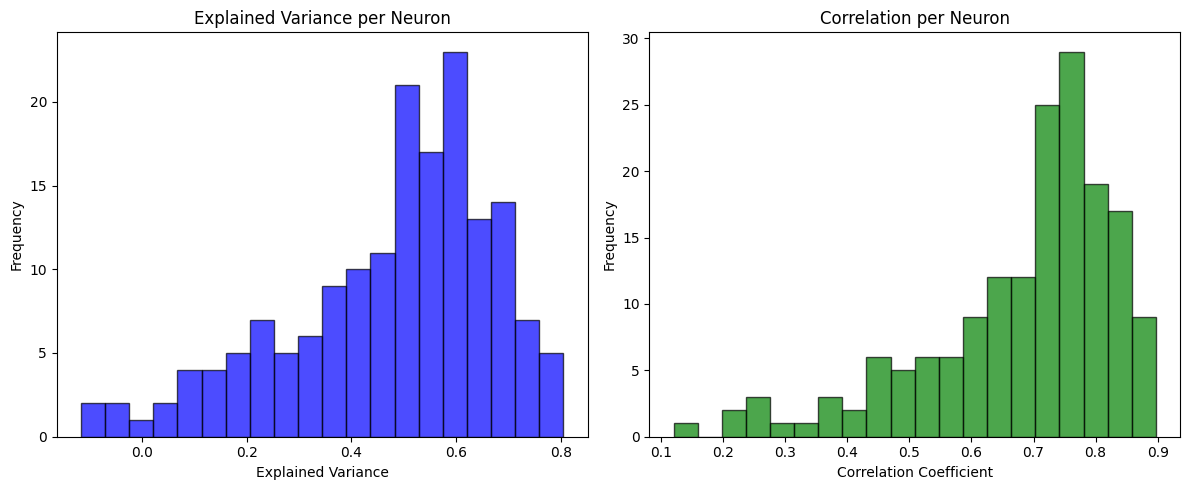

In [20]:
# Evaluate model on the validation set
evaluate_model(model2, val_dataloader, spikes_val, device="cpu")

### pnasnet5large




In [21]:
# ------------------------------------------------------------------
#  PNASNet‑5 Large backbone pretrained on ImageNet‑1k
# ------------------------------------------------------------------
import timm, torch.nn as nn

backbone = timm.create_model("pnasnet5large", pretrained=True)

# ------------------------------------------------------------------
#  Replace the ImageNet head with a NUM_NEURONS regression head
#     timm models use different attribute names, so check in order
# ------------------------------------------------------------------
if hasattr(backbone, "classifier"):          # many EfficientNet‑style models
    in_features = backbone.classifier.in_features
    backbone.classifier = nn.Linear(in_features, n_neurons)
elif hasattr(backbone, "fc"):                # ResNet‑style
    in_features = backbone.fc.in_features
    backbone.fc = nn.Linear(in_features, n_neurons)
elif hasattr(backbone, "head"):              # ViT / ConvNeXt‑style
    in_features = backbone.head.in_features
    backbone.head = nn.Linear(in_features, n_neurons)
elif hasattr(backbone, "last_linear"):       # Inception / PNASNet
    in_features = backbone.last_linear.in_features
    backbone.last_linear = nn.Linear(in_features, n_neurons)
else:
    raise AttributeError("Cannot locate final classifier layer.")

model3 = backbone.cuda()
print(f"PNASNet‑5 Large parameters: {sum(p.numel() for p in model3.parameters()):,}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/345M [00:00<?, ?B/s]

PNASNet‑5 Large parameters: 82,462,596


In [22]:
optimizer = optim.AdamW(model3.parameters(), lr=learning_rate)

In [23]:
#Uses original scheduler
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_model(model3, train_dataloader, val_dataloader, loss_function, optimizer, epochs=15, device=device)

Epoch 1/15, Train Loss: 0.1166, Val Loss: 0.1069
Epoch 2/15, Train Loss: 0.0936, Val Loss: 0.0885
Epoch 3/15, Train Loss: 0.0825, Val Loss: 0.0839
Epoch 4/15, Train Loss: 0.0745, Val Loss: 0.0811
Epoch 5/15, Train Loss: 0.0678, Val Loss: 0.0744
Epoch 6/15, Train Loss: 0.0598, Val Loss: 0.0668
Epoch 7/15, Train Loss: 0.0560, Val Loss: 0.0660
Epoch 8/15, Train Loss: 0.0539, Val Loss: 0.0650
Epoch 9/15, Train Loss: 0.0517, Val Loss: 0.0645
Epoch 10/15, Train Loss: 0.0496, Val Loss: 0.0641
Epoch 11/15, Train Loss: 0.0469, Val Loss: 0.0635
Epoch 12/15, Train Loss: 0.0455, Val Loss: 0.0635
Epoch 13/15, Train Loss: 0.0438, Val Loss: 0.0632
Epoch 14/15, Train Loss: 0.0417, Val Loss: 0.0632
Epoch 15/15, Train Loss: 0.0391, Val Loss: 0.0638


Overall explained variance: 0.4674
Overall correlation: 0.6732


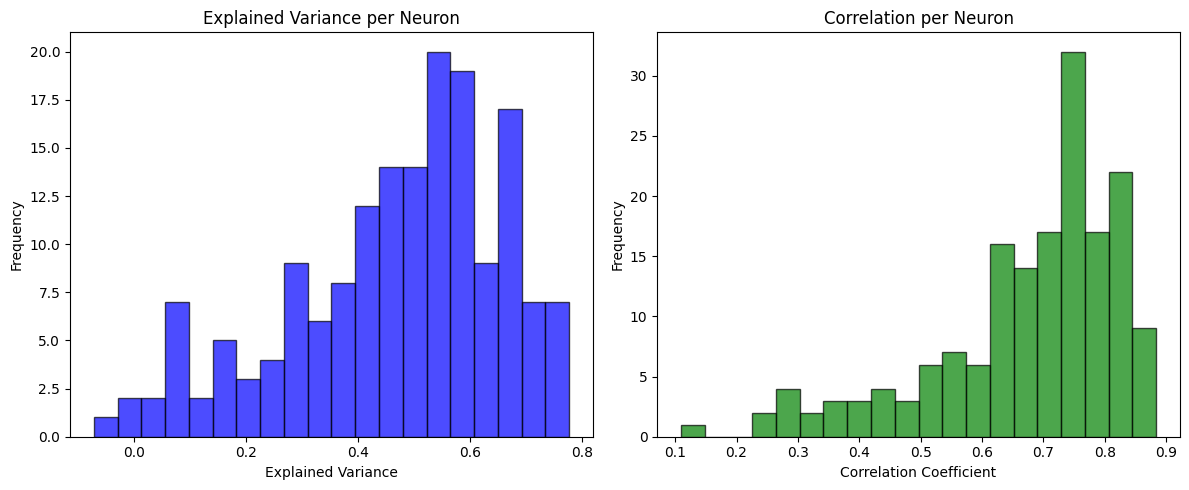

In [24]:
# Evaluate model on the validation set
evaluate_model(model3, val_dataloader, spikes_val, device="cpu")

###  Trying DeepNet201 with a new optimizer (adadelta):

In [25]:
from torchvision.models import densenet201, DenseNet201_Weights

# Load ImageNet‑pretrained backbone
backbone = densenet201(weights=DenseNet201_Weights.IMAGENET1K_V1)

# Replace classifier: DenseNet uses nn.Linear(in_features, 1000) by default
in_features = backbone.classifier.in_features
n_neurons = spikes_train.shape[1]

backbone.classifier = nn.Linear(in_features, n_neurons)

model4 = backbone.cuda()
print(f"Model parameters: {sum(p.numel() for p in model4.parameters()):,}")

Model parameters: 18,415,656


In [26]:
import torch

import torch

# ── group params: decay vs no‑decay (optional but often useful) ─────────
decay, no_decay = [], []
for n, p in model4.named_parameters():
    if p.requires_grad:
        (no_decay if p.dim() == 1 or 'bias' in n.lower() else decay).append(p)

optimizer = torch.optim.Adadelta(
    [
        {'params': decay,    'weight_decay': 5e-4},   # or 0.0 on first run
        {'params': no_decay, 'weight_decay': 0.0},
    ],
    lr=1.0,         # Adadelta default
    rho=0.9,
    eps=1e-6,
)

# Define the loss function
loss_function = nn.MSELoss()

In [27]:
#Uses original scheduler
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_model(model4, train_dataloader, val_dataloader, loss_function, optimizer, epochs=15, device=device)

Epoch 1/15, Train Loss: 0.1433, Val Loss: 0.1010
Epoch 2/15, Train Loss: 0.0934, Val Loss: 0.0952
Epoch 3/15, Train Loss: 0.0805, Val Loss: 0.0843
Epoch 4/15, Train Loss: 0.0715, Val Loss: 0.0818
Epoch 5/15, Train Loss: 0.0661, Val Loss: 0.0836
Epoch 6/15, Train Loss: 0.0512, Val Loss: 0.0678
Epoch 7/15, Train Loss: 0.0484, Val Loss: 0.0675
Epoch 8/15, Train Loss: 0.0477, Val Loss: 0.0675
Epoch 9/15, Train Loss: 0.0466, Val Loss: 0.0677
Epoch 10/15, Train Loss: 0.0460, Val Loss: 0.0674
Epoch 11/15, Train Loss: 0.0452, Val Loss: 0.0676
Epoch 12/15, Train Loss: 0.0451, Val Loss: 0.0676
Epoch 13/15, Train Loss: 0.0453, Val Loss: 0.0675
Epoch 14/15, Train Loss: 0.0451, Val Loss: 0.0680
Epoch 15/15, Train Loss: 0.0447, Val Loss: 0.0675


Overall explained variance: 0.4363
Overall correlation: 0.6516


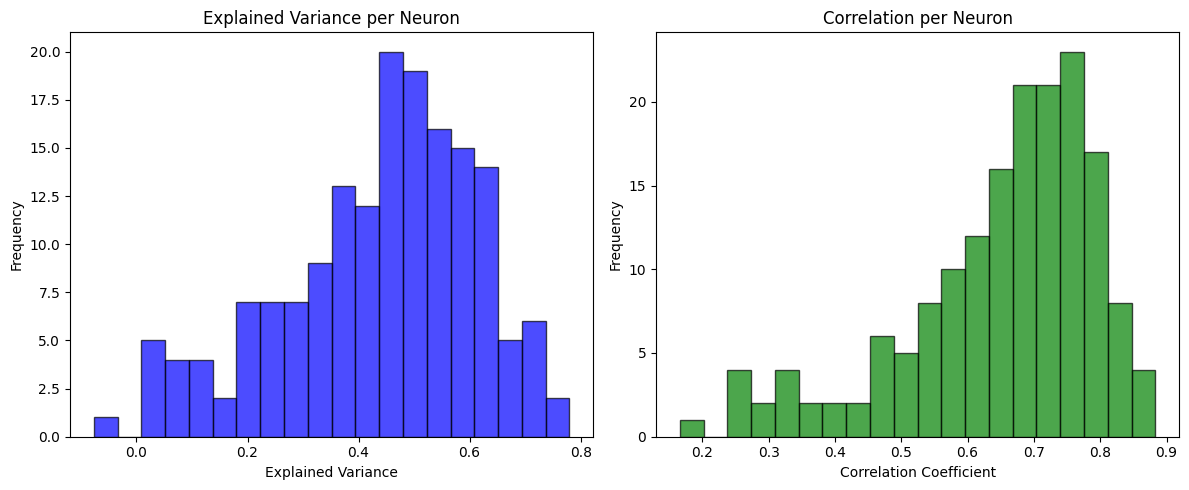

In [28]:
# Evaluate model on the validation set
evaluate_model(model4, val_dataloader, spikes_val, device="cpu")

### Trying DeepNet201 with a new optimizer (RAdam)

In [29]:
from torchvision.models import densenet201, DenseNet201_Weights

# Load ImageNet‑pretrained backbone
backbone = densenet201(weights=DenseNet201_Weights.IMAGENET1K_V1)

# Replace classifier: DenseNet uses nn.Linear(in_features, 1000) by default
in_features = backbone.classifier.in_features
n_neurons = spikes_train.shape[1]

backbone.classifier = nn.Linear(in_features, n_neurons)

model5 = backbone.cuda()
print(f"Model parameters: {sum(p.numel() for p in model5.parameters()):,}")

Model parameters: 18,415,656


In [30]:
import torch

# split params so BatchNorm & biases are exempt from decay
decay, no_decay = [], []
for n, p in model5.named_parameters():
    (no_decay if p.dim()==1 or 'bias' in n.lower() else decay).append(p)

optimizer = torch.optim.RAdam(
    [
        {'params': decay,    'weight_decay': 1e-2},
        {'params': no_decay, 'weight_decay': 0.0},
    ],
    lr=2e-4, betas=(0.9, 0.999), eps=1e-8
)

# cosine LR schedule (optional but usually helpful)
num_epochs = 30


In [31]:
#Uses original scheduler
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_model(model5, train_dataloader, val_dataloader, loss_function, optimizer, epochs=15, device=device)

Epoch 1/15, Train Loss: 0.1896, Val Loss: 0.1468
Epoch 2/15, Train Loss: 0.1188, Val Loss: 0.1101
Epoch 3/15, Train Loss: 0.0957, Val Loss: 0.0925
Epoch 4/15, Train Loss: 0.0830, Val Loss: 0.0855
Epoch 5/15, Train Loss: 0.0747, Val Loss: 0.0821
Epoch 6/15, Train Loss: 0.0642, Val Loss: 0.0729
Epoch 7/15, Train Loss: 0.0603, Val Loss: 0.0725
Epoch 8/15, Train Loss: 0.0583, Val Loss: 0.0724
Epoch 9/15, Train Loss: 0.0563, Val Loss: 0.0723
Epoch 10/15, Train Loss: 0.0553, Val Loss: 0.0734
Epoch 11/15, Train Loss: 0.0517, Val Loss: 0.0707
Epoch 12/15, Train Loss: 0.0513, Val Loss: 0.0714
Epoch 13/15, Train Loss: 0.0556, Val Loss: 0.0733
Epoch 14/15, Train Loss: 0.0581, Val Loss: 0.0728
Epoch 15/15, Train Loss: 0.0587, Val Loss: 0.0761


Overall explained variance: 0.4094
Overall correlation: 0.6330


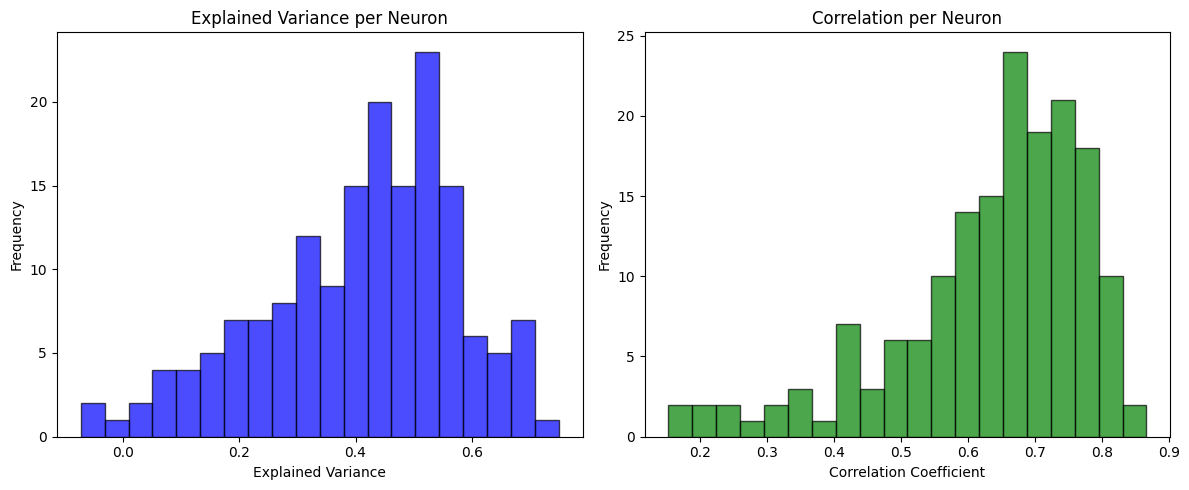

In [32]:
# Evaluate model on the validation set
evaluate_model(model5, val_dataloader, spikes_val, device="cpu")

Similar disapointing results with AdamW..

### Trying other densenet models

### DenseNet169

In [33]:
from torchvision.models import densenet169, DenseNet169_Weights

# Load ImageNet‑pretrained backbone
backbone = densenet169(weights=DenseNet169_Weights.IMAGENET1K_V1)

# Replace classifier: DenseNet uses nn.Linear(in_features, 1000) by default
in_features = backbone.classifier.in_features
n_neurons = spikes_train.shape[1]

backbone.classifier = nn.Linear(in_features, n_neurons)

model6 = backbone.cuda()
print(f"Model parameters: {sum(p.numel() for p in model6.parameters()):,}")

Model parameters: 12,764,200


In [34]:
optimizer = optim.Adam(model6.parameters(), lr=learning_rate)

In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_model(model6, train_dataloader, val_dataloader, loss_function, optimizer, epochs=10, device=device, scheduler=scheduler)

Epoch 1/10, Train Loss: 0.1171, Val Loss: 0.1042
Epoch 2/10, Train Loss: 0.0914, Val Loss: 0.0851
Epoch 3/10, Train Loss: 0.0808, Val Loss: 0.0849
Epoch 4/10, Train Loss: 0.0742, Val Loss: 0.0766
Epoch 5/10, Train Loss: 0.0678, Val Loss: 0.0905
Epoch 6/10, Train Loss: 0.0640, Val Loss: 0.0712
Epoch 7/10, Train Loss: 0.0589, Val Loss: 0.0731
Epoch 8/10, Train Loss: 0.0543, Val Loss: 0.0715
Epoch 9/10, Train Loss: 0.0487, Val Loss: 0.0666
Epoch 10/10, Train Loss: 0.0449, Val Loss: 0.0655


Overall explained variance: 0.4897
Overall correlation: 0.6886


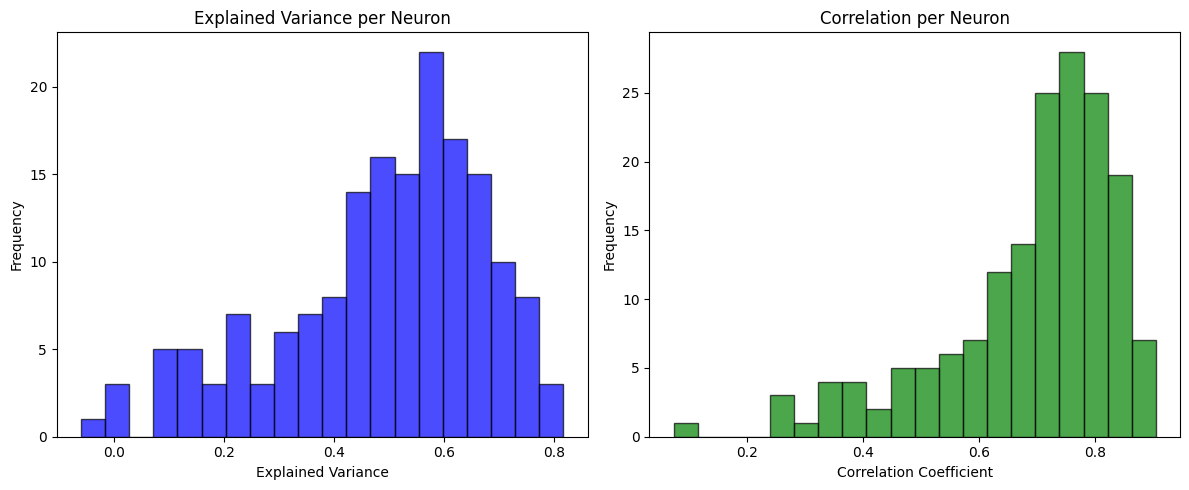

In [36]:
# Evaluate model on the validation set
evaluate_model(model6, val_dataloader, spikes_val, device="cpu")

### Densenet161

In [37]:
from torchvision.models import densenet161, DenseNet161_Weights

# Load ImageNet‑pretrained backbone
backbone = densenet161(weights=DenseNet161_Weights.IMAGENET1K_V1)

# Replace classifier: DenseNet uses nn.Linear(in_features, 1000) by default
in_features = backbone.classifier.in_features
n_neurons = spikes_train.shape[1]

backbone.classifier = nn.Linear(in_features, n_neurons)

model8 = backbone.cuda()
print(f"Model parameters: {sum(p.numel() for p in model8.parameters()):,}")

Model parameters: 26,843,112


In [38]:
optimizer = optim.Adam(model8.parameters(), lr=learning_rate)

In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_model(model8, train_dataloader, val_dataloader, loss_function, optimizer, epochs=10, device=device, scheduler=scheduler)

Epoch 1/10, Train Loss: 0.1174, Val Loss: 0.0987
Epoch 2/10, Train Loss: 0.0887, Val Loss: 0.0873
Epoch 3/10, Train Loss: 0.0785, Val Loss: 0.0824
Epoch 4/10, Train Loss: 0.0721, Val Loss: 0.0762
Epoch 5/10, Train Loss: 0.0663, Val Loss: 0.0885
Epoch 6/10, Train Loss: 0.0612, Val Loss: 0.0758
Epoch 7/10, Train Loss: 0.0565, Val Loss: 0.0751
Epoch 8/10, Train Loss: 0.0518, Val Loss: 0.0669
Epoch 9/10, Train Loss: 0.0472, Val Loss: 0.0725
Epoch 10/10, Train Loss: 0.0427, Val Loss: 0.0634


Overall explained variance: 0.4878
Overall correlation: 0.6888


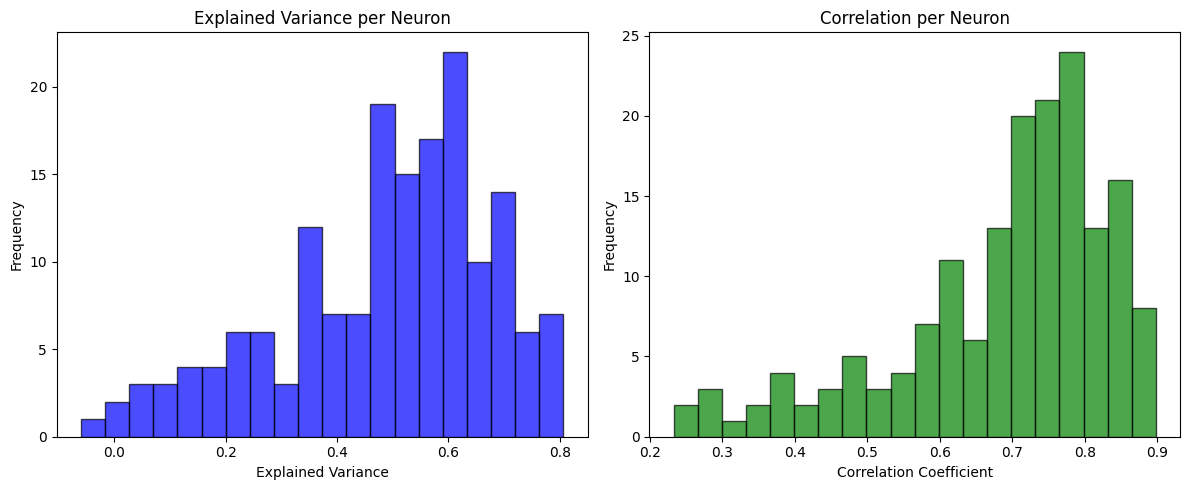

In [40]:
# Evaluate model on the validation set
evaluate_model(model8, val_dataloader, spikes_val, device="cpu")


Densenet121

In [41]:
from torchvision.models import densenet121, DenseNet121_Weights

# Load ImageNet‑pretrained backbone
backbone = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)

# Replace classifier: DenseNet uses nn.Linear(in_features, 1000) by default
in_features = backbone.classifier.in_features
n_neurons = spikes_train.shape[1]

backbone.classifier = nn.Linear(in_features, n_neurons)

model9 = backbone.cuda()
print(f"Model parameters: {sum(p.numel() for p in model9.parameters()):,}")

Model parameters: 7,126,056


In [42]:
optimizer = optim.Adam(model9.parameters(), lr=learning_rate)

In [43]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_model(model9, train_dataloader, val_dataloader, loss_function, optimizer, epochs=10, device=device, scheduler= scheduler)

Epoch 1/10, Train Loss: 0.1164, Val Loss: 0.0970
Epoch 2/10, Train Loss: 0.0861, Val Loss: 0.0827
Epoch 3/10, Train Loss: 0.0768, Val Loss: 0.0810
Epoch 4/10, Train Loss: 0.0700, Val Loss: 0.0761
Epoch 5/10, Train Loss: 0.0646, Val Loss: 0.0885
Epoch 6/10, Train Loss: 0.0594, Val Loss: 0.0741
Epoch 7/10, Train Loss: 0.0550, Val Loss: 0.0701
Epoch 8/10, Train Loss: 0.0506, Val Loss: 0.0701
Epoch 9/10, Train Loss: 0.0457, Val Loss: 0.0660
Epoch 10/10, Train Loss: 0.0403, Val Loss: 0.0668


Overall explained variance: 0.4852
Overall correlation: 0.6852


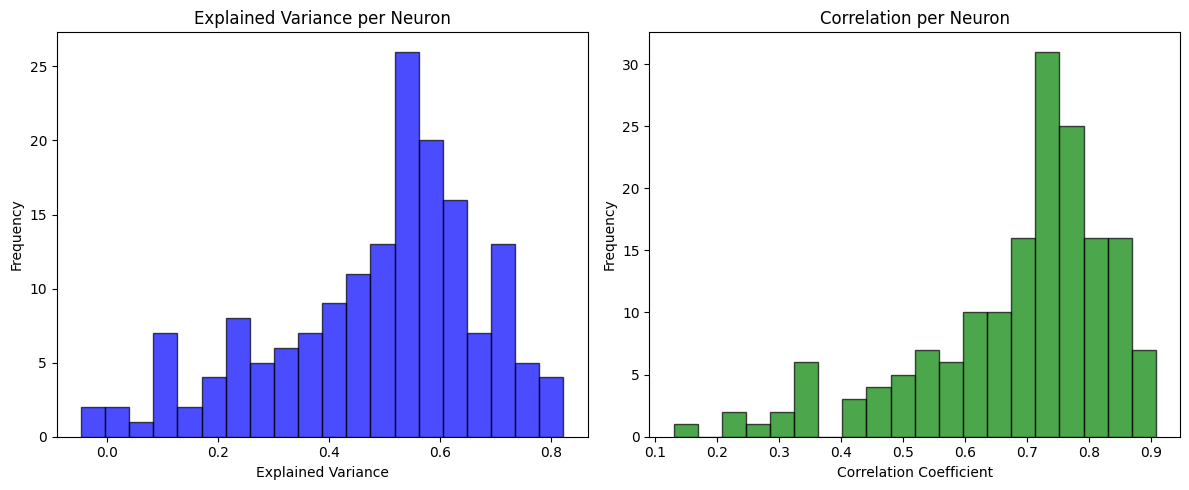

In [44]:
# Evaluate model on the validation set
evaluate_model(model9, val_dataloader, spikes_val, device="cpu")
